In [2]:
import pandas as pd
import seaborn as sns
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pickle
pd.set_option('max_colwidth', -1)

In [3]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split

# Загрузка данных

In [6]:
df = pd.read_excel('/data/detail_price/ТВЗ/Таблички с данными/Выгрузка Номенклатура 011 06022020.xlsx')
df = df.drop('Unnamed: 0', axis=1).dropna()
df.columns = df.iloc[0].values
df = df.drop([4])
df = df.drop(['Характеристика номенклатуры', 'Валюта', 'Суммарное время изготовления, дни'], axis=1)

In [7]:
df1= pd.read_excel('/data/detail_price/ТВЗ/Таблички с данными/Выгрузка Нормы времени 011 06022020.xlsx')
df1 = df1.drop('Unnamed: 0', axis=1).dropna()
df1.columns = df1.iloc[0].values
df1 = df1.drop([2])

In [8]:
df1['Норма Времени'] = df1['Норма Времени'].astype(str).apply(lambda v: v.replace(',','.')).astype(float)

In [9]:
df.head(10)

,Номенклатура,"Артикул, черт.номер",Размер,Масса ДЕС,Масса заготовки,Материал,Цена
6,КРОНШТЕЙН черт. 4458.12.07.151,4458.12.07.151,4Х131Х725,2.04,2.98,Лист Б-ПН-О-4х1500х3000 ГОСТ 19903-74 / Ст3сп5 ГОСТ 14637-89,172.66
7,ПЛАНКА черт. 4458.10.00.057,4458.10.00.057,0.55Х475Х600,0.1,1.23,"Рулон БТ-БШ-О-0,55х1250 08пс-ОН-НР-1",102.75
8,ЛИСТ черт. 4458.12.07.152,4458.12.07.152,1.4Х102Х477,0.38,0.535,"Рулон АТ-БШ-О-1,4х1200 ГОСТ 19904-90 / К310В-4-III-15пс-св ГОСТ 16523-97",30.48
9,ПЛАНКА черт. 4458.10.00.058,4458.10.00.058,0.55Х475Х600,0.1,1.23,"Рулон БТ-БШ-О-0,55х1250 08пс-ОН-НР-1",96.14
10,КРОНШТЕЙН черт. 4458.12.07.091,4458.12.07.091,4Х236Х725,3.5,5.37,Лист Б-ПН-О-4х1500х3000 ГОСТ 19903-74 / Ст3сп5 ГОСТ 14637-89,302.46
11,РЕБРО черт. 4075.42.257,4075.42.257,12Х98Х140,0.9,1.292,Лист А-ПВ-О-12х1500х6000 ГОСТ 19903-2015 / Ст3сп5-св ГОСТ 14637-89,88.15
12,ПОЛОСА черт. 4075.42.259,4075.42.259,6Х62Х195,0.57,0.57,Лист Б-ПН-О-6х1500х3000 ГОСТ 19903-2015 / Ст3сп5-св ГОСТ 14637-89,32.51
13,РЕБРО черт. 4075.42.261.1,4075.42.261.1,12Х98Х140,0.8,0.816,Лист А-ПВ-О-12х1500х6000 ГОСТ 19903-2015 / Ст3сп5-св ГОСТ 14637-89,84.33
14,ВСТАВКА черт. 4075.42.252,4075.42.252,6Х80Х310,0.85,1.019,Лист Б-ПН-О-6х1500х3000 ГОСТ 19903-2015 / Ст3сп5-св ГОСТ 14637-89,68.41
15,УГОЛОК черт. 4458.12.04.121,4458.12.04.121,2Х34Х68,0.03,0.036,Рулон АТ-БШ-О-2х1250 ГОСТ 19904-90 / ГОСТ 16523-97 К310В-4-III-15пс-св,5.12


In [11]:
df1.head()

,Номенклатура,Характеристика номенклатуры,Номер операции,Норма Времени,Операция,"Операция, код",Описание операции
3,СКОБА черт. 4447.62.00.111,[011],5,0.003823,Отрезка,2101,резка
4,СКОБА черт. 4447.62.00.111,[011],10,0.004742,Гибка,2129,гибка за 2х. пр.
5,"Кольцо, черт. В-60М2.0901-42",[011] 090,6,0.014982,Правка,2156,Правка
6,"Кольцо, черт. В-60М2.0901-42",[011] 090,10,0.167733,Профильно-вырезная электрофизическая лучевая лазерная,7512,лазерная резка
7,"Кольцо, черт. В-60М2.0901-42",[011] 090,15,0.026369,Обдирочно-шлифовальная,4137,обнаждачить


In [10]:
df = df.merge(df1.groupby('Номенклатура')['Норма Времени'].sum(), on='Номенклатура')
df.head(15)

,Номенклатура,"Артикул, черт.номер",Размер,Масса ДЕС,Масса заготовки,Материал,Цена,Норма Времени
0,КРОНШТЕЙН черт. 4458.12.07.151,4458.12.07.151,4Х131Х725,2.04,2.98,Лист Б-ПН-О-4х1500х3000 ГОСТ 19903-74 / Ст3сп5 ГОСТ 14637-89,172.66,0.120642
1,ПЛАНКА черт. 4458.10.00.057,4458.10.00.057,0.55Х475Х600,0.1,1.23,"Рулон БТ-БШ-О-0,55х1250 08пс-ОН-НР-1",102.75,0.054229
2,ЛИСТ черт. 4458.12.07.152,4458.12.07.152,1.4Х102Х477,0.38,0.535,"Рулон АТ-БШ-О-1,4х1200 ГОСТ 19904-90 / К310В-4-III-15пс-св ГОСТ 16523-97",30.48,0.009667
3,ПЛАНКА черт. 4458.10.00.058,4458.10.00.058,0.55Х475Х600,0.1,1.23,"Рулон БТ-БШ-О-0,55х1250 08пс-ОН-НР-1",96.14,0.054229
4,КРОНШТЕЙН черт. 4458.12.07.091,4458.12.07.091,4Х236Х725,3.5,5.37,Лист Б-ПН-О-4х1500х3000 ГОСТ 19903-74 / Ст3сп5 ГОСТ 14637-89,302.46,0.141904
5,РЕБРО черт. 4075.42.257,4075.42.257,12Х98Х140,0.9,1.292,Лист А-ПВ-О-12х1500х6000 ГОСТ 19903-2015 / Ст3сп5-св ГОСТ 14637-89,88.15,0.037322
6,ПОЛОСА черт. 4075.42.259,4075.42.259,6Х62Х195,0.57,0.57,Лист Б-ПН-О-6х1500х3000 ГОСТ 19903-2015 / Ст3сп5-св ГОСТ 14637-89,32.51,0.010147
7,РЕБРО черт. 4075.42.261.1,4075.42.261.1,12Х98Х140,0.8,0.816,Лист А-ПВ-О-12х1500х6000 ГОСТ 19903-2015 / Ст3сп5-св ГОСТ 14637-89,84.33,0.039794
8,ВСТАВКА черт. 4075.42.252,4075.42.252,6Х80Х310,0.85,1.019,Лист Б-ПН-О-6х1500х3000 ГОСТ 19903-2015 / Ст3сп5-св ГОСТ 14637-89,68.41,0.036682
9,УГОЛОК черт. 4458.12.04.121,4458.12.04.121,2Х34Х68,0.03,0.036,Рулон АТ-БШ-О-2х1250 ГОСТ 19904-90 / ГОСТ 16523-97 К310В-4-III-15пс-св,5.12,0.007626


# Обработка данных

In [277]:
material_categories = dict()
# material_categories[0] = 'too rare'

materials = df['Материал'].copy()

c = 1
for cat in materials.apply(lambda s: s.split()[0].lower()).drop_duplicates().tolist():
    #print("'%s': %d," % (cat, c))
    print(cat)
    material_categories[cat] = c
    c += 1

лист
рулон
профиль
жесть
круг
петля
проволока
лента
сетка
прокат


In [499]:
def filter_correct_dims(dims):
    dims_ = []
    for d in dims:
        try:
            dims_.append(float(d))
        except ValueError:
            pass
    return dims_

        
df = df[df['Размер'].apply(lambda s: len(filter_correct_dims(s.lower().split('х'))) == 3)]

mul = lambda arr: arr[0] * mul(arr[1:]) if len(arr) > 1 else arr[0]
calc_vol = lambda params: mul([float(x) for x in filter_correct_dims(params.lower().split('х'))])
calc_dims = lambda s: np.array([float(x) for x in filter_correct_dims(s.lower().split('х'))])
# def get_material(s):
#     mat = s.split()[0].lower()
#     if mat not in ('лист', 'рулон'):
#         mat = 'too_rare'
#     return mat
get_material = lambda s: s.split()[0].lower()


ndf = pd.DataFrame()
# raw features
ndf['size1'] = df['Размер'].apply(calc_dims).apply(lambda v: sorted(v)[0])
ndf['size2'] = df['Размер'].apply(calc_dims).apply(lambda v: sorted(v)[1])
ndf['size3'] = df['Размер'].apply(calc_dims).apply(lambda v: sorted(v)[2])
ndf['volume'] = (list(map(calc_vol, df['Размер'])))
ndf['mass'] = (df['Масса заготовки'].astype(float))

# mass features
ndf['userful_mass_perc'] = (df['Масса ДЕС'] / df['Масса заготовки']).astype(float)
ndf['log_mass'] = np.log1p(ndf.mass)
ndf['sqrt_mass'] = np.sqrt(ndf.mass)
ndf['sqr_trash_mass'] = np.square((df['Масса заготовки'] - df['Масса ДЕС']).astype(float))

# volume features
ndf['log_volume'] = np.log1p(ndf.volume)

# other features
ndf['density']  = ndf['mass'] / ndf['volume']
# ndf['material_category'] = df['Материал'].apply(lambda mat: get_material(mat))

ndf['log_price'] = np.log(df['Цена'].astype(float))

# Drop unneccessary
# ndf = ndf.drop(['size%d'% i for i in [1]],axis=1)
# ndf = ndf.drop('mass volume'.split(), axis=1)
ndf = ndf[ndf.log_price < 10]


indexed = ndf.copy()
indexed['detail_name'] = df['Номенклатура']
indexed.to_csv('featured_details_mape014.csv', index=False)

ndf.head(10)

,size1,size2,size3,volume,mass,userful_mass_perc,log_mass,sqrt_mass,sqr_trash_mass,log_volume,density,log_price
6,4.00,131.0,725.0,379900.0,2.980,0.684564,1.381282,1.726268,0.883600,12.847666,0.000008,5.151324
7,0.55,475.0,600.0,156750.0,1.230,0.081301,0.802002,1.109054,1.276900,11.962414,0.000008,4.632299
8,1.40,102.0,477.0,68115.6,0.535,0.710280,0.428530,0.731437,0.024025,11.128976,0.000008,3.417071
9,0.55,475.0,600.0,156750.0,1.230,0.081301,0.802002,1.109054,1.276900,11.962414,0.000008,4.565805
10,4.00,236.0,725.0,684400.0,5.370,0.651769,1.851599,2.317326,3.496900,13.436299,0.000008,5.711949
11,12.00,98.0,140.0,164640.0,1.292,0.696594,0.829425,1.136662,0.153664,12.011523,0.000008,4.479040
12,6.00,62.0,195.0,72540.0,0.570,1.000000,0.451076,0.754983,0.000000,11.191907,0.000008,3.481548
13,12.00,98.0,140.0,164640.0,0.816,0.980392,0.596636,0.903327,0.000256,12.011523,0.000005,4.434738
14,6.00,80.0,310.0,148800.0,1.019,0.834151,0.702602,1.009455,0.028561,11.910365,0.000007,4.225519
15,2.00,34.0,68.0,4624.0,0.036,0.833333,0.035367,0.189737,0.000036,8.439232,0.000008,1.633154


In [494]:
# f = plt.figure(figsize=(10,10))
# sns.heatmap(ndf.corr(), annot=True, square=True)

# Model

In [500]:
split = 0.1
X = ndf.drop('log_price', axis=1).to_numpy()
Y = ndf['log_price'].to_numpy()

trainX, testX, trainY, testY = train_test_split(X, Y, test_size=split, random_state=27)
print(trainX.shape, testX.shape, trainY.shape, testY.shape)

(27125, 11) (3014, 11) (27125,) (3014,)


In [481]:
iters = 1200

cbm = CatBoostRegressor(iterations=iters,
                        random_seed=27,
                        learning_rate=0.02,
                        l2_leaf_reg=0.3,
                        depth=4,
                        one_hot_max_size=20,
                        cat_features=np.where(ndf.dtypes == np.object)[0],
                        loss_function='MAPE',
                        verbose=iters//10)

cbm.fit(trainX, trainY, eval_set=(testX, testY))

0:	learn: 0.4199982	test: 0.4295429	best: 0.4295429 (0)	total: 5.07ms	remaining: 6.08s
120:	learn: 0.2135936	test: 0.2222784	best: 0.2222784 (120)	total: 663ms	remaining: 5.91s
240:	learn: 0.1849683	test: 0.1931990	best: 0.1931990 (240)	total: 1.1s	remaining: 4.37s
360:	learn: 0.1783403	test: 0.1865633	best: 0.1865633 (360)	total: 1.51s	remaining: 3.51s
480:	learn: 0.1755830	test: 0.1838608	best: 0.1838608 (480)	total: 1.95s	remaining: 2.91s
600:	learn: 0.1735393	test: 0.1818810	best: 0.1818810 (600)	total: 2.39s	remaining: 2.38s
720:	learn: 0.1723459	test: 0.1809403	best: 0.1809356 (710)	total: 2.8s	remaining: 1.86s
840:	learn: 0.1721056	test: 0.1810032	best: 0.1808749 (732)	total: 3.22s	remaining: 1.37s
960:	learn: 0.1717488	test: 0.1807837	best: 0.1807832 (959)	total: 3.65s	remaining: 907ms
1080:	learn: 0.1714800	test: 0.1805444	best: 0.1805444 (1080)	total: 4.1s	remaining: 451ms
1199:	learn: 0.1712664	test: 0.1803115	best: 0.1803105 (1198)	total: 4.51s	remaining: 0us

bestTest = 0.

In [482]:
# cbm.save_model('./service/weights.cbm')
np.where(ndf.dtypes == np.object)

(array([], dtype=int64),)

# Analyze model

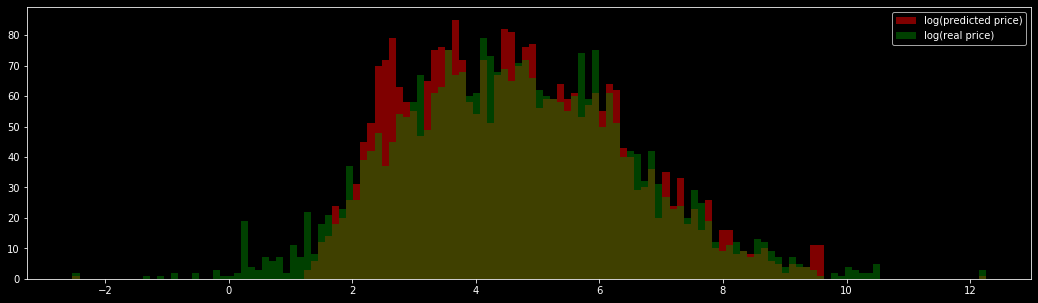

In [382]:
pred_price = cbm.predict(testX)
# normalization
min_el = min(min(pred_price), min(testY))
max_el = max(max(pred_price), max(testY))
pred_price = np.array(list(pred_price) + [min_el, max_el])
testY_      = np.array(list(testY)      + [min_el, max_el])

bins = 130
f = plt.figure(figsize=(18, 5))
errs = np.abs(testY_ - pred_price)
f = plt.hist((pred_price), bins=bins, alpha=0.5, color='red')
f = plt.hist((testY_), bins=bins, alpha=0.5, color='green')
plt.legend(['log(predicted price)', 'log(real price)'])
# f = plt.hist(np.log(errs), bins=30, alpha=0.5)
plt.savefig('pred_prce.png')

In [383]:
for fname, fval in sorted(zip(ndf.columns.to_list()[:-1], cbm.feature_importances_), key=lambda v: -v[1]):
    print('%10s -- %.2f' % (fname, fval))

log_volume -- 30.15
 sqrt_mass -- 22.58
   density -- 19.07
  log_mass -- 18.91
     size3 -- 4.93
     size1 -- 1.81
material_category -- 1.43
     size2 -- 0.82
userful_mass_perc -- 0.30
